In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import geopandas as gpd

## Location Feature Gap Statistic

The gap statistic is a method that will allow the automatic selection of the number of centroids to be used within the data pipeline. 

The gap statistic is new to me, so the notebook will comprise of information regarding the Gap statistic, followed by its use in automatic the optimal k-selection to be used within the data pipeline. 

References on the Gap statistic include: 
- https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
- https://anaconda.org/milesgranger/gap-statistic/notebook 

The below summaries give attribution to Tim Lohr's Medium Blog post, with the link posted above.

### K-means Summary
1. Assign each data point to its nearest centroid. Calculate the euclidian distance between all points to its centroid. 
2. Calculate the mean for each centroid based on its assigned data points and move the centroid to the middle of the assigned data points. 
3. Repeat steps [1, 2] until convergence is achieved. Convergence is defined as a centroid remaining in approximate the same position within the bounds of epsilon.

Note the initialization of the centroids plays a massive role in how quickly the algorithm reaches convergence.
Notes, that the within cluster distance shrinks with the more additional clusters added, until such a point as there are as many clusters as there are data points, achieving a within cluster erroro of 0.

### Gap Statistics

$$K* = argmin_{k} \{K|G(K) \ge G(K + 1) - s'_{K+1} \}$$
Estimating K* by HTF The Elements of Statistical Learning on page 519 | 14.3.11 Practical Issues

Where, G(K) and $s'_{K+1}$ are defined below:
- Introduce two data matrices data_points and average_distribution (avg distribution of within cluster distances)

$$G(K) = log(\text{average distribution}) - log(\text{data points})$$
$$s'_{K+1} = s_k * \sqrt{1 + 1/20}$$
$$s_k = \text{std } log(\text{average distribution}) \text{  over 20 runs}$$

##### Notice
- Changes in distance are very high for the first few centroid changes. The more centroids intorudced the smaller the required changes in position. 

#### Basic Idea
- Choose K where the biggerst jump of within cluster distance occured. 
- $s_{K+1}$ acts as a threshold to remove small alterations. 

The below optimal k method is from: https://anaconda.org/milesgranger/gap-statistic/notebook. Fully code ownership rights are givens to the author Miles Granger. Minor alterations have been made in order to fit it to the use-case below. 

In [3]:
def optimalK(data, nrefs=3):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
    Returns: (gaps, optimalK)
    """
    maxClusters = 100  # Dynamically generate maximum clusters as the number of data points.
    gaps = np.zeros((len(range(1, maxClusters)),))  # Create a container to store the gap statistics for each k-value
    resultsdf = pd.DataFrame({'centroids':[], 'gap':[]})  # Create a dataframe to store k-values and Gap statistics results
    for gap_index, k in enumerate(range(1, maxClusters)):  # Iterate over all values of k from 1- maxClusters

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, n_init=10)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k, n_init=10)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = pd.concat([resultsdf, pd.DataFrame({'centroids':[k], 'gap':[gap]})])

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

## Location Feature Adaption

Idea: The dataset used has two features, latitude and longitdue, creating a geographic location. These features are required to be simplified and one-hot-encoded in order to be used effectively for machile learning algorithms. 
K-means algorithm is used to determine cluster centroids, or hostposts of wildlife observations that can be used to generalize, and reduce the location feature. 

However each dataset is unique and dependent upon taxonomic level, hence for each model the K-means may require varying numbers of centroids. Use the Gap statistic measure to determine the optiml k centroids per dataset. 

#### Proboscidia Test Run

In [4]:
file_path = '../data/processed/'

In [5]:
def aggregate_data(observation_file: str, meta_file: str) -> pd.DataFrame:
    obs_df = pd.read_csv(file_path + observation_file, index_col=0)
    meta_df = pd.read_csv(file_path + meta_file, index_col=0)

    obs_df = obs_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])
    meta_df = meta_df.drop(columns=['lat', 'long', 'time'])

    df = pd.merge(obs_df, meta_df, how='inner', left_index=True, right_index=True)
    return df

In [8]:
df = aggregate_data('proboscidia_
                    final.csv', 'proboscidia_meta.csv')

In [9]:
df.head()

,latitude,longitude,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id,...,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,
4126,-19.502735,23.298196,30562.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC-ND,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,...,0.0,0.0,0.0,2009-07-25T06:57,2009-07-25T18:09,17.0,37.4,132.0,19.05,4.18
16344,-17.946449,25.100015,30699.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,...,0.3,0.0,1.0,2007-11-30T05:33,2007-11-30T18:42,17.2,37.1,55.0,28.63,6.28
16346,-20.253259,25.194044,30490.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,...,0.0,0.0,0.0,2007-11-30T05:29,2007-11-30T18:46,18.0,41.0,29.0,26.25,6.35
17083,-19.595253,23.228511,30562.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,...,2.6,0.0,2.0,2007-11-27T05:37,2007-11-27T18:51,11.8,29.2,23.0,25.99,6.40
17097,-18.422570,24.012110,30649.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,...,0.3,0.0,1.0,2007-11-16T05:37,2007-11-16T18:39,13.1,34.2,50.0,26.98,6.84


Showcase the original locations from the dataset.

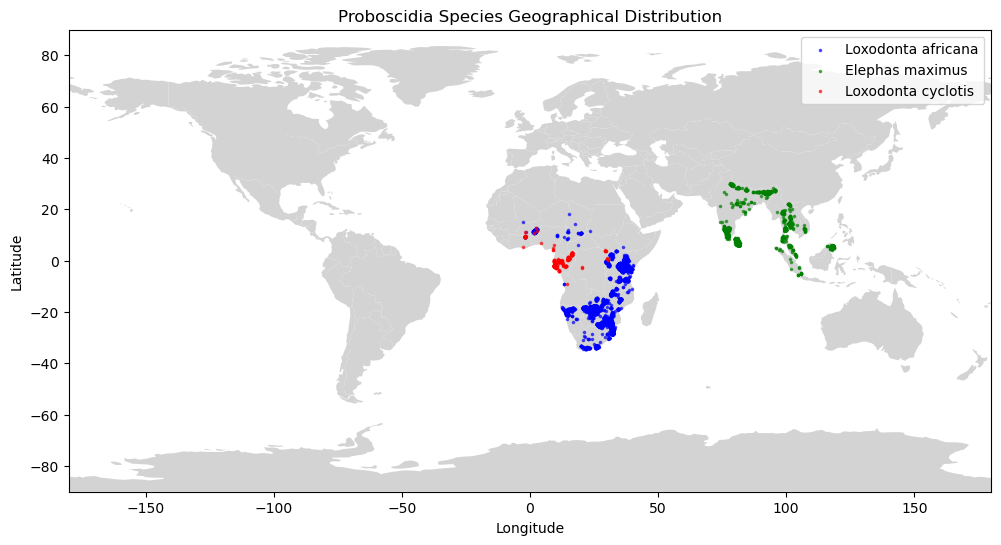

In [8]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


colours = {'Loxodonta africana': 'tab:blue', 
           'Elephas maximus': 'tab:green',
          'Loxodonta cyclotis': 'tab:red'}

# Africana Species
africana_df = df[df['taxon_species_name'] == 'Loxodonta africana']
africana_x = africana_df['longitude']
africana_y = africana_df['latitude']

# Maximus Species
maximus_df = df[df['taxon_species_name'] == 'Elephas maximus']
maximus_x = maximus_df['longitude']
maximus_y = maximus_df['latitude']

#Cyclotis
cyc_df = df[df['taxon_species_name'] == 'Loxodonta cyclotis']
cyc_x = cyc_df['longitude']
cyc_y = cyc_df['latitude']

# Scatter plots
scatter = plt.scatter(africana_x, africana_y, s=2.5, alpha=0.6, c='blue', label='Loxodonta africana')
scatter = plt.scatter(maximus_x, maximus_y, s=2.5, alpha=0.6, c='green', label='Elephas maximus')
scatter = plt.scatter(cyc_x, cyc_y, s=2.5, alpha=0.6, c='red', label='Loxodonta cyclotis')


# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Proboscidia Species Geographical Distribution")
plt.legend()

plt.show()

Execute the Gap Statistic algorithm of the latitude and longitude features of the Elephant dataset. Plot the resulting k centroids to determine how well they generalize the observations.

In [10]:
location_df = df[['latitude', 'longitude']]

In [33]:
k, gap_analysis = optimalK(location_df, 3)

In [34]:
print(k)

98


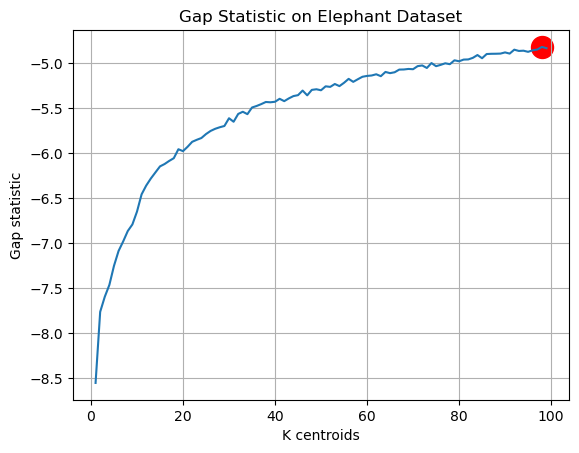

In [35]:
plt.plot(gap_analysis['centroids'], gap_analysis['gap'])
plt.scatter(gap_analysis[gap_analysis['centroids'] == k]['centroids'], 
            gap_analysis[gap_analysis['centroids'] == k]['gap'], s=250, c='r')

plt.grid(True)
plt.xlabel('K centroids')
plt.ylabel('Gap statistic')
plt.title('Gap Statistic on Elephant Dataset')
plt.show()

### Gaps Statistic Analysis

The above plot shows a steadily rising gap statistic measure well into k=100 cerntroids and above. This method is proving to be too delicate and selective in the number of centroids it produces. An optimal method for the above problem is required to make a robust decision that captures coarse scale features indicating observation hotspots. 
Alternative methods are required to be looked into below. 

## Silhoute Score

Reference for code for Silhoute score from: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

#### Basic Explanation
The Silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters. 
The Silhouette score ranges between [-1, 1]. A negative score indicates that we have created too few or too many clusters.

In [6]:
def calculate_optimal_k(data, k_max, interval, k_init):
    sil = []
    
    k = k_init
    while k <= k_max:
        k_means = KMeans(n_clusters=k,  n_init=10).fit(data)
        labels = k_means.labels_

        sil.append(silhouette_score(data, labels))
        
        k += interval
    return sil

In [29]:
sil_scores = calculate_optimal_k(location_df, 30, 1, 2)
k_values = range(2, 31, 1)

In [27]:
silhouette_optimal = np.argmax(sil_scores)
print(k_values[silhouette_optimal])

13


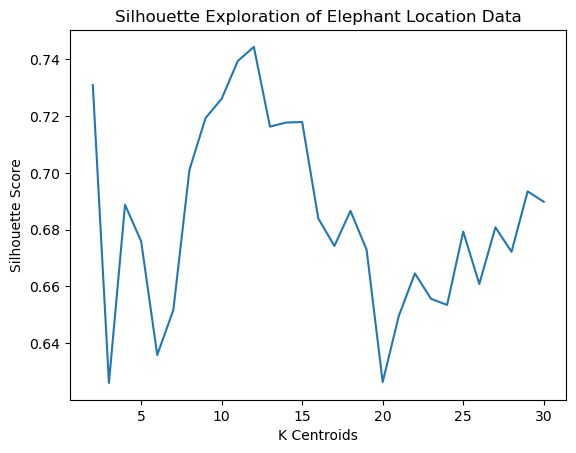

In [30]:
plt.plot(k_values, sil_scores)

plt.xlabel('K Centroids')
plt.ylabel('Silhouette Score')
plt.title('ASilhouette Exploration of Elephant Location Data')
plt.show()

Verify number of clusters by plotting onto world map.

In [31]:
k_means = KMeans(n_clusters=13, n_init=10)
k_means.fit(location_df)
clusters = k_means.cluster_centers_

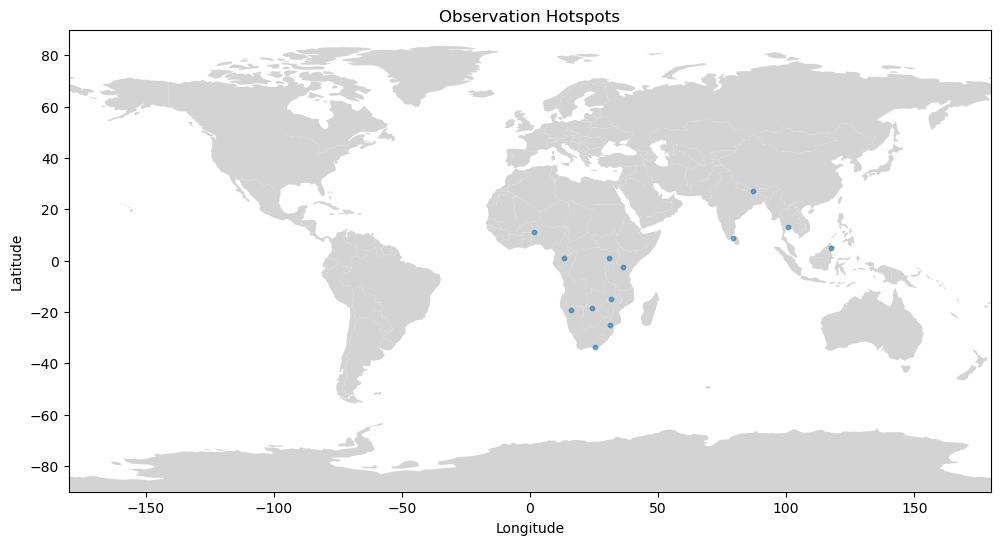

In [32]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

latitude = clusters[:, 0]
longitude = clusters[:, 1]

plt.scatter(longitude, latitude, s=10, alpha=0.6)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Observation Hotspots")

plt.show()

The Silhouette score seems to be capturing the observation hotspots appropriately using the Elephant dataset. The Silhoutte score generates a k-value of 13. This is close to the elbow score evaluated at 18-20. For further proof of concept in the applied case. The Silhouette score will be generated on the Felid dataset next. 

### Felid Application

In [10]:
df = aggregate_data('felids_final.csv', 'felids_meta.csv')

Remove Catus catus (Common housecat) as the inclusion of this non-wildlife species removes all variance from  the dataset.

In [11]:
df = df[df['taxon_species_name'] != 'Felis catus']

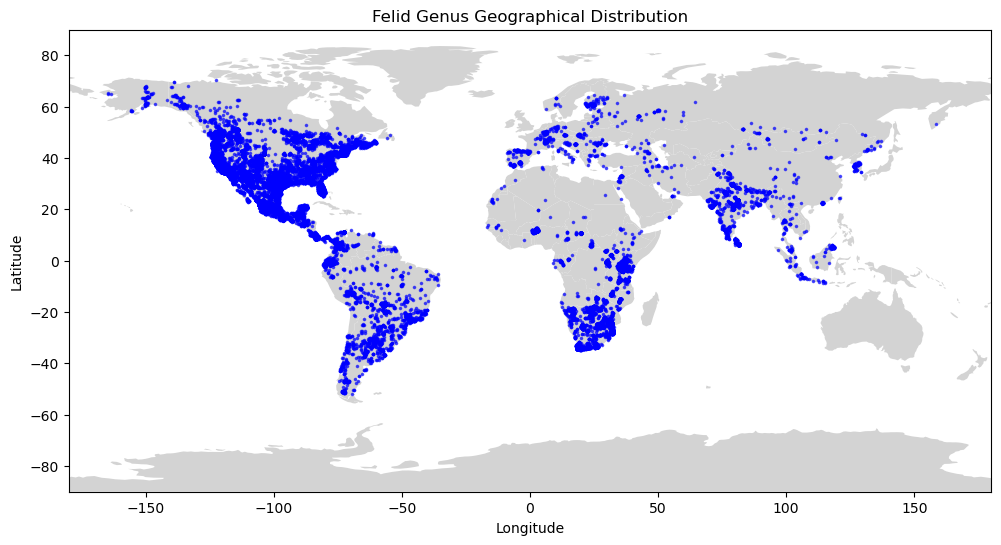

In [12]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

x = df['longitude']
y = df['latitude']

scatter = plt.scatter(x, y, s=2.5, alpha=0.6, c='blue')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Felid Genus Geographical Distribution")

plt.show()

In [13]:
location_df = df[['latitude', 'longitude']]

In [14]:
sil_scores = calculate_optimal_k(location_df, 102, 2, 5)

In [19]:
k_values = range(5, 102, 2)

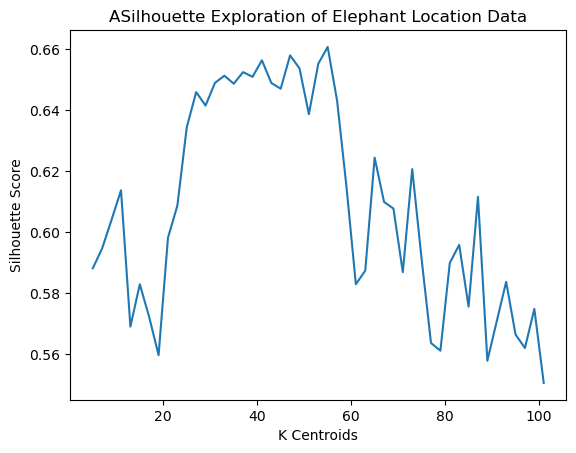

In [20]:
plt.plot(k_values, sil_scores)

plt.xlabel('K Centroids')
plt.ylabel('Silhouette Score')
plt.title('ASilhouette Exploration of Elephant Location Data')
plt.show()

In [21]:
silhouette_optimal = np.argmax(sil_scores)
print(k_values[silhouette_optimal])

55


In [22]:
k_means = KMeans(n_clusters=55, n_init=10)
k_means.fit(location_df)
clusters = k_means.cluster_centers_

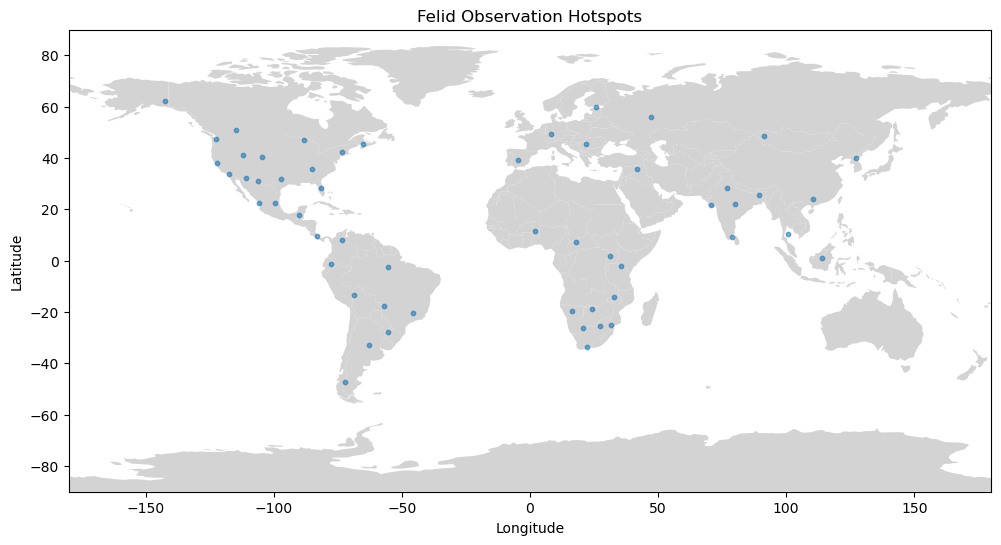

In [23]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

latitude = clusters[:, 0]
longitude = clusters[:, 1]

plt.scatter(longitude, latitude, s=10, alpha=0.6)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Felid Observation Hotspots")

plt.show()

The Silhouette score coincides with the elbow method in selecting an approximate number of centroids within the range of 55-60 centroids. The verification of the Silhouette method on both Wildlife families is verification fo the utility of this method, and as such it will be used within the modelling pipeline to automate the selection of k-location features.